# General workflow
This workflow is a starting point to demonstrate the functionality of the containers and to detect and classify difficult cases

In [1]:
import numpy as np
import pandas as pd
import skimage
import Images
import ModelUNet_v2 #version 2 learns areas and boundaries of nuclei
import matplotlib.pyplot as plt
import tqdm
import copy
import scipy
#import plotly #plan to do interactive plots

C:\Users\BKY\AppData\Local\Programs\Python\Python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#some definitions
debug=False #perform on a subset --> faster
model_shape=(256,256,3) #works with shape (2^x, 2^x) only?
model_name='unet_{}x{}_xent_v2'.format(model_shape[0],model_shape[1])
if debug:
    model_name += '_debug'

print('the model will be called \''+model_name+'\'')


the model will be called 'unet_256x256_xent_v2'


## Training
* load training data
* train the model (if not yet done)
* 

100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:14<00:00,  9.00it/s]


     size_x  size_y  n_channels  nuclei_n  nuclei_meanSz  nuclei_stdSz  \
143     520     696           1        23           1933           733   

     nuclei_minSz  nuclei_maxSz  
143           329          3699  


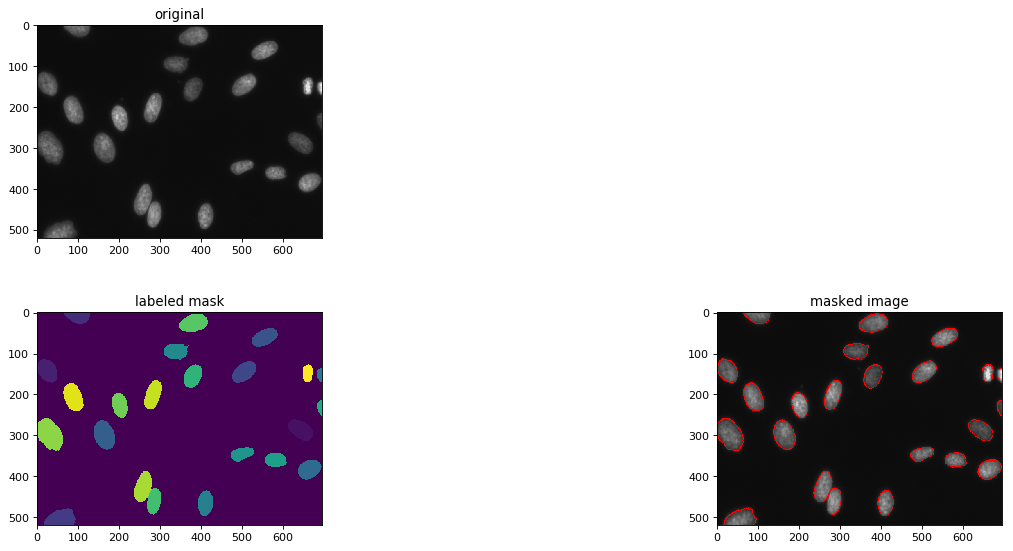

In [3]:
train=Images.Images("../input/stage1_train")
if debug:
    #subselect, to make it faster 
    train=train.subset(idx=range(20))
    #todo: overload [] to get this

#set aside 10% for validation
val=train.subset(np.arange(train.n()*.9, train.n()))
#train=train.subset(np.arange(train.n()*.9,))
train=train.subset(np.arange(train.n(),))

#load the image files (in original size)    
train.load_images()
train.load_masks()
train.features.head()    
plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')

train.show_image()

In [4]:
# initialize and train the model 
# to detect unlabled masks (e.g. the forground vs background)

model=ModelUNet_v2.ModelUNet(name=model_name, shape=model_shape)
#question: should the model design be adapted according to image dimensions?
if not model.trained:
    model.fit_model(train)


found area model file unet_256x256_xent_v2_area.h5
found boundary model file unet_256x256_xent_v2_boundary.h5


predicting area...
predicting boundaries...
labeling predictions...


  0%|                                                                                          | 0/670 [00:00<?, ?it/s]C:\Users\BKY\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\morphology\extrema.py:111: FutureWarning: Conversion of the second argument of issubdtype from `'half'` to `np.floating` is deprecated. In future, it will be treated as `np.float16 == np.dtype('half').type`.
  if np.issubdtype(img.dtype, 'half'):
C:\Users\BKY\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\segmentation\_join.py:118: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if not np.issubdtype(label_field.dtype, np.int):
100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:25<00:00, 26.74it/s]


computing scores... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [02:06<00:00,  5.29it/s]


   size_x  size_y  n_channels  nuclei_n  nuclei_meanSz  nuclei_stdSz  \
0     256     256           1        27            211           132   
1     256     256           1        36            131            37   
2     256     320           3        70            419           208   
3     256     320           3        86            168           151   
4     256     320           3         7            813           402   

   nuclei_minSz  nuclei_maxSz  n_pred  mean_size_pred    ...     iou_th50  \
0            21           460    22.0        1.159897    ...     0.542857   
1            35           276    37.0        1.638870    ...     1.000000   
2            56          1067    91.0       16.544727    ...     0.555556   
3            22           752    80.0       11.434180    ...     0.237410   
4           152          1563     6.0        0.239185    ...     0.555556   

   iou_th55  iou_th60  iou_th65  iou_th70  iou_th75  iou_th80  iou_th85  \
0  0.500000  0.500000  0.4594

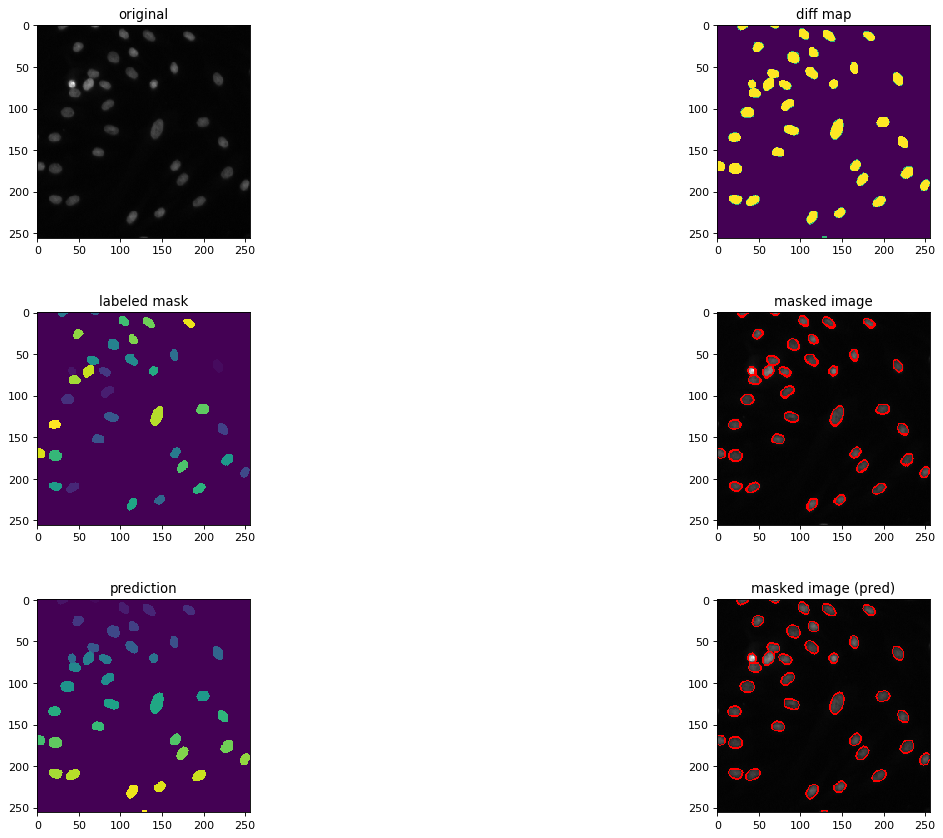

In [5]:

#add_pred ruft models.predict auf, das folgendes macht:
# 1) area prediction (wie im beispiel von dem wir geklaut haben)
# 2) boundaries prediction (tolle neue innovation von uns)
# 3) beides nutzen um die labels zu asignen
# 4) rescalen zur originalgröße


#add labled predictions to container
train.add_predictions(model)
# this adds iou scores to train.features and train.nuc_features
# scores berechnen dautert ca 1 sec pro bild... ich berechne ne menge scores

print( train.features.drop(['ids'], axis=1).head() ) 
print("expected LB score(train): {}".format(np.mean(train.features['iou_score'])))
fig=plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')

train.show_image()

   size_x  size_y  n_channels  nuclei_n  nuclei_meanSz  nuclei_stdSz  \
1     256     256           1        36            131            37   

   nuclei_minSz  nuclei_maxSz  n_pred  mean_size_pred    ...     iou_th50  \
1            35           276    37.0         1.63887    ...          1.0   

   iou_th55  iou_th60  iou_th65  iou_th70  iou_th75  iou_th80  iou_th85  \
1       1.0       1.0       1.0       1.0       1.0  0.756098  0.285714   

   iou_th90  iou_th95  
1  0.107692  0.043478  

[1 rows x 22 columns]


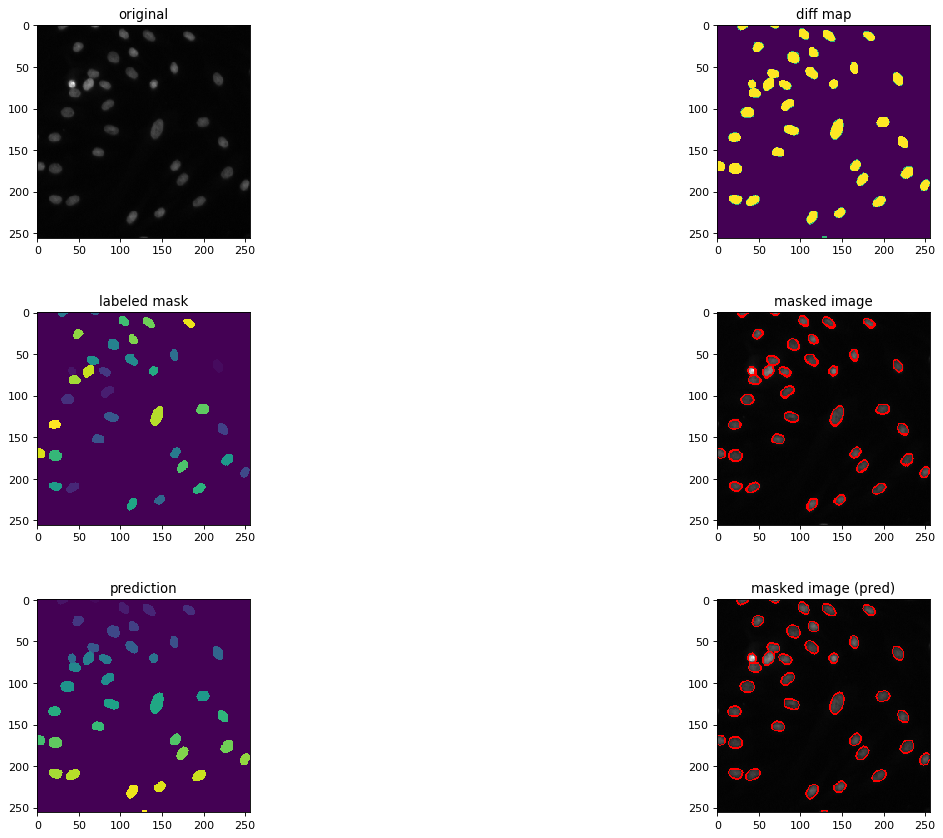

,img_id,nuc_i,size,boundary,iou
27,1,1,140,42.627417,0.848485
28,1,2,82,30.727922,0.836735
29,1,3,159,46.627417,0.917647
30,1,4,142,44.041631,0.793296
31,1,5,152,43.213203,0.808511
32,1,6,123,41.213203,0.878571
33,1,7,139,41.798990,0.951724
34,1,8,111,37.798990,0.828358
35,1,9,132,42.142136,0.889655
36,1,10,162,46.384776,0.885246


In [6]:
image_id=1
plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
train.show_image(image_id)
#print(train.nuc_features.head())

train.nuc_features.loc[train.nuc_features['img_id']==image_id,:]

     size_x  size_y  n_channels  nuclei_n  nuclei_meanSz  nuclei_stdSz  \
524     256     256           1        76            321           136   

     nuclei_minSz  nuclei_maxSz  n_pred  mean_size_pred    ...     iou_th50  \
524            22           646    70.0       13.882416    ...     0.634409   

     iou_th55  iou_th60  iou_th65  iou_th70  iou_th75  iou_th80  iou_th85  \
524  0.617021       0.6   0.55102  0.535354  0.475728  0.345133  0.178295   

     iou_th90  iou_th95  
524  0.041096       0.0  

[1 rows x 22 columns]


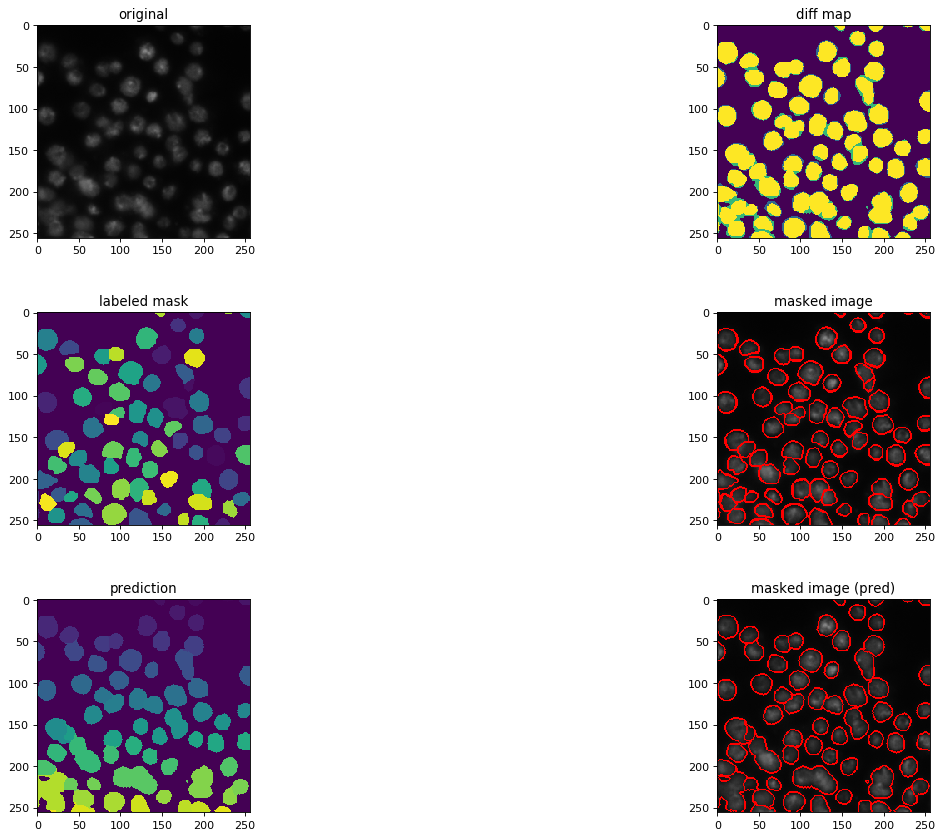

In [7]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
train.show_image()

In [8]:
#same on validation data
val.load_images()
val.load_masks()
_val=copy.deepcopy(val)
val.add_predictions(model,boundary_height=0.05)
val.features.drop(['ids'], axis=1).head()
print("expected LB score(val): {}".format(np.mean(val.features['iou_score'])))


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 13.93it/s]


predicting area...
predicting boundaries...
labeling predictions...


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]C:\Users\BKY\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\morphology\extrema.py:111: FutureWarning: Conversion of the second argument of issubdtype from `'half'` to `np.floating` is deprecated. In future, it will be treated as `np.float16 == np.dtype('half').type`.
  if np.issubdtype(img.dtype, 'half'):
C:\Users\BKY\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\segmentation\_join.py:118: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if not np.issubdtype(label_field.dtype, np.int):
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.78it/s]


computing scores... 


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  7.56it/s]


expected LB score(val): 0.4890413292740775


In [9]:
#find optimum
mean_score=[]
for h in np.arange(0.01,.1,.01):
    _v=copy.deepcopy(_val)
    _v.add_predictions(model,boundary_height=h)
    score=np.mean(_v.features['iou_score'])
    print("expected LB score({}): {}".format(h, score))
    mean_score.append(score)
#optimal hight ~0.06

predicting area...
predicting boundaries...
labeling predictions...


  0%|                                                                                           | 0/67 [00:00<?, ?it/s]C:\Users\BKY\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\morphology\extrema.py:111: FutureWarning: Conversion of the second argument of issubdtype from `'half'` to `np.floating` is deprecated. In future, it will be treated as `np.float16 == np.dtype('half').type`.
  if np.issubdtype(img.dtype, 'half'):
C:\Users\BKY\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\segmentation\_join.py:118: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if not np.issubdtype(label_field.dtype, np.int):
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 28.55it/s]


computing scores... 


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  7.47it/s]


expected LB score(0.01): 0.4712420170139781
predicting area...
predicting boundaries...
labeling predictions...


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 27.39it/s]


computing scores... 


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  7.58it/s]


expected LB score(0.02): 0.48146548466535677
predicting area...
predicting boundaries...
labeling predictions...


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 29.24it/s]


computing scores... 


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:09<00:00,  7.43it/s]


expected LB score(0.03): 0.4857949169472324
predicting area...
predicting boundaries...
labeling predictions...


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 28.22it/s]


computing scores... 


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:09<00:00,  7.32it/s]


expected LB score(0.04): 0.48732997081121615
predicting area...
predicting boundaries...
labeling predictions...


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 27.91it/s]


computing scores... 


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:09<00:00,  7.34it/s]


expected LB score(0.05): 0.4890413292740775
predicting area...
predicting boundaries...
labeling predictions...


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 28.94it/s]


computing scores... 


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:09<00:00,  7.09it/s]


expected LB score(0.060000000000000005): 0.4898247199601452
predicting area...
predicting boundaries...
labeling predictions...


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 27.11it/s]


computing scores... 


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:09<00:00,  7.31it/s]


expected LB score(0.06999999999999999): 0.4920434334574763
predicting area...
predicting boundaries...
labeling predictions...


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 29.32it/s]


computing scores... 


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:09<00:00,  7.27it/s]


expected LB score(0.08): 0.48502423971141545
predicting area...
predicting boundaries...
labeling predictions...


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 28.80it/s]


computing scores... 


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:09<00:00,  7.28it/s]


expected LB score(0.09): 0.4837491387032781


In [10]:
#whats going on here????
#step by step
#pa=model.predict_area(val).reshape((-1,)+model_shape[:2])
#pb=model.predict_boundary(val).reshape((-1,)+model_shape[:2])
idx=12
plt.imshow(pa[idx].reshape(pa[idx].shape[:2]))
plt.show()

plt.imshow(pb[idx].reshape(pb[idx].shape[:2]))
plt.show()

#those are OK!


NameError: name 'pa' is not defined

In [ ]:
import skimage.restoration
#import peakutils
th=0.5
idx=0
lab_pred=np.zeros_like(pa, dtype=np.uint)
local_maxi=np.zeros_like(pa, dtype=np.uint)
markers=np.zeros_like(pa, dtype=np.uint)
i=idx
#for i in tqdm.tqdm(range(pa.shape[0])):
if 1:
    #get at least one pixel in each nuclei that is not connected to another
    _pa=copy.deepcopy(pa[i])
    _pb=copy.deepcopy(pb[i])
    _lab=scipy.ndimage.label(_pa>th)[0]
    _dist=scipy.ndimage.distance_transform_edt(_pa>.5)
    #_pb[_pb<.02]=0
    #_pb=skimage.restoration.denoise_tv_chambolle(_pb,multichannel=False)
    #local_maxi[i]=skimage.feature.peak_local_max(1-_pb, indices=False,threshold_rel=.9 , labels=_lab, exclude_border=3,min_distance=1 )
    local_maxi[i]=skimage.morphology.h_maxima((1-_pb), h=.01)
    local_maxi[i][_pa<th]=0
    #local_maxi[i]=skimage.feature.corner_peaks(1-_pb, indices=False,threshold_rel=.9 , labels=_lab, exclude_border=3)
    #label these starts
    markers[i] = scipy.ndimage.label(local_maxi[i])[0]
    lab_pred[i] = skimage.morphology.watershed(_pb, markers[i], mask=_pa>th)
    #lab_pred[i][_pa<th]=0
    lab_pred[i]=skimage.segmentation.relabel_sequential(lab_pred[i])[0]


In [ ]:



plt.imshow(val.images[idx])
plt.show()
plt.imshow(_lab)
plt.show()
#plt.imshow(local_maxi[idx])
#plt.show()

#plt.imshow(markers[idx])
#plt.show()

plt.imshow(lab_pred[idx])
plt.show()


In [ ]:
val.features['iou_score']

In [ ]:
idx=0
fig=plt.figure(figsize=(18, 12), dpi= 150, facecolor='w', edgecolor='k')
val.show_image(idx)

plt.imshow(pa[idx].reshape(pa[idx].shape[:2]))
plt.show()

plt.imshow(pb[idx].reshape(pb[idx].shape[:2]))
plt.show()



## Prediction (on test data)
* load test data
* use model to predict masks
* prepare submission file

In [11]:
test=Images.Images("../input/stage1_test")

#load the image files (in original size)    
test.load_images()
print('making predictions...')
test.add_predictions(model,boundary_height=0.06)
#much faster, no scores to calculate


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 48.98it/s]


making predictions...
predicting area...
predicting boundaries...
labeling predictions...


  0%|                                                                                           | 0/65 [00:00<?, ?it/s]C:\Users\BKY\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\morphology\extrema.py:111: FutureWarning: Conversion of the second argument of issubdtype from `'half'` to `np.floating` is deprecated. In future, it will be treated as `np.float16 == np.dtype('half').type`.
  if np.issubdtype(img.dtype, 'half'):
C:\Users\BKY\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\segmentation\_join.py:118: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if not np.issubdtype(label_field.dtype, np.int):
100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 26.42it/s]


In [12]:
submission_file='submission_' + model_name + '.csv'
test.write_submission(submission_file)



0

In [13]:

##########
# scores #
##########
print('Scores for first test image:')
#unlabeled IOU
print('IoU: {}'.format(Images.iou(val.masks[0] > 0, unlab_pred[0]>0.5)))
#labled IOUs per nucleus
print('IoU per nucleus: {}'.format(Images.iou(val.masks[0], val.pred[0])))
#mean IOU
print('mean IoU: {}'.format(np.mean(Images.iou(val.masks[0], val.pred[0]))))
# fraction of nuclei > th
print('fraction of nuclei has IoU > 0.5: {}'.format(Images.iou_score(val.masks[0], val.pred[0], th=[.5])))
print('fraction of nuclei has IoU > 0.95: {}'.format(Images.iou_score(val.masks[0], val.pred[0], th=[.95])))
# fraction of nuclei > th average over range of thresholds
print('IoU score (over range of thresholds): {}'.format(Images.iou_score(val.masks[0], val.pred[0])))

val.show_image(0)

Scores for first test image:


NameError: name 'unlab_pred' is not defined